# Drzewa Wzmacniane Gradientowo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import Node

## Zadanie 1
W tym zadaniu będziesz implementował algorytm Gradient Boosting Trees dla problemu regresji. Aby zaimplementować ten algorytm dostępny jest obiekt `Node` implementujący drzewo regresyjne. Jest to odpowiednio dostosowany obiekt, który implementowałeś w pierwszym zadaniu domowym. Możesz wykorzystać swoją własną implementację (i dostosować ją wg. opisu poniżej) lub skorzystać z implementacji w pliku `helpers`.

W stosunku do poprzedniej implementacji obiekt ma pewne dodatkowe cechy, które umożliwią sprawniejszą implementację:
- W konstruktorze `Node` jest teraz jeden obowiązkowy argument `calculate_leaf_value`, do którego należy wstawić funkcję, która jest wywoływana przez algorytm w momencie tworzenia liścia celem obliczenia jego wartości. W standardowym drzewie regresji algorytm tworzący liść oblicza jego wartość jako średnią wartość jego elementów. Jeśli chcielibyśmy uzyskać takie działanie, powinniśmy zaimplementować następującą funkcję:

```python
def mean_val_leaf(X, y, last_predicted):
    return np.mean(y)

tree = Node(calculate_leaf_value=mean_val_leaf)
```
Zwróć uwagę na parametry funkcji tworzącej liść: `X`, `y` charakteryzujące obiekty w liściu oraz `last_predicted` przechowujące aktualną predykcję klasyfikatora dla tych obiektów. Poprzez aktualną predykcję rozumiemy tu predykcję uzyskaną wszystkimi dotychczas stworzonymi klasyfikatorami bazowymi w GBT (czyli wynik osiągnięty pozostałymi drzewami niż to tworzone). Argument `last_predicted` na chwilę obecną wydaje się niepotrzebny, lecz będzie on potrzebny do realizacji zadania.

- Dodatkowe argumenty obsługuje też funkcja ucząca model `fit(X, y, last_predicted, max_depth = None)` - która dostaje na wejście wcześniej wspomniane `last_predicted` oraz argument `max_depth` wstrzymujący budowę zbyt głębokich drzew. Innych mechanizmów pruningu niezaimplementowano, jeśli jednak takowe istnieją w Twojej implementacji, możesz je wykorzystać.

Stwórz zbiór danych do regresji poniższym kodem:

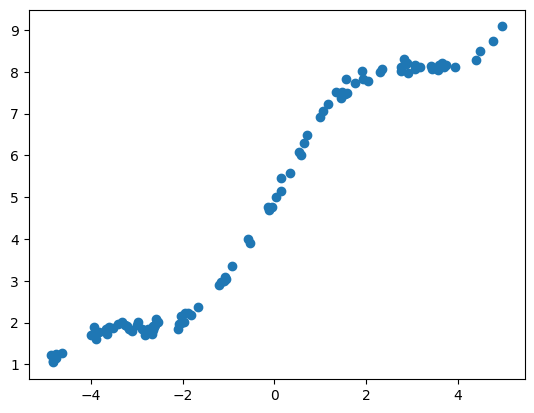

In [62]:
X = np.random.uniform(-5,5,100)
y = 5 + X + np.sin(X) + np.random.normal(scale=0.1, size=100)
plt.plot(X,y,'o')
X = np.expand_dims(X, axis=1)

Zaimplementuj algorytm GBT dla błędu kwadratowego. Aby to zrobić należy uzupełnić w ogólnym pseudokodzie przedstawionym na zajęciach trzy elementy:
- model początkowy $F_0(x)$ zwracający stałą wartość $v$ która optymalizuje błąd:
$$F_0(x) = \arg \min_v \sum_{i=1}^N L(y_i, v) $$
- wzór na wartość ujemnego gradientu tj. pseudo-rezyduum:
$$r_i  =  - \frac{\partial}{\partial \hat{y_i}} L(y_i, \hat{y_i}) $$
gdzie $\hat{y_i}$ to aktualna predykcja klasyfikatora tj. w $m$-tej iteracji $\hat{y_i}=F_m(x)$
- wzór na wartość liścia $v$ optymalizujący funkcję celu całego modelu GBT
$$v = \arg \min_v \sum_{i=1}^{N_l} L(y_i, F_{m-1}(x_i) + v) $$
Zwróć uwagę, że suma iteruje tylko po instancjach w liściu (${N_l}$ to liczba elementów w liściu).

Wyznacz powyższe wartości (rozwiązania dla referencji poniżej komórki z kodem) i zaimplementuj algorytm. 

In [63]:
class GBTRegressor(object):
    
    def __init__(self):
        self.trees = [] # Lista kolejnych drzew (Node) klasyfikatora
        self.initial_model = None # Model początkowy, zwracający stałą wartość 
                                  #(zmienna po prostu przechowuje tę wartość)
        self.pseudo_residuals = []
        
    def calc_leaf(self, X, y, last_predicted):
        """
        Funkcja do wykorzystania jako argument klasyfikatora bazowego Node
        """
        return np.mean(y)
        
    def fit(self, X, y, M = 100, max_depth = 1):
        """ 
        Funckja trenująca model GBT o M klasyfikatora bazowych
        z maksymalną głębkością pojedynczego drzewa max_depth
        """
        self.initial_model = np.mean(y)
        mean_score = np.array([np.mean(y) for _ in y])

        for _ in range(M):
            res = y - mean_score
            self.pseudo_residuals.append(res)
            tree = Node(calculate_leaf_value=self.calc_leaf)
            tree.fit(X, res, last_predicted=mean_score, max_depth=max_depth)
            mean_score += tree.predict(X)
            self.trees.append(tree)
            
    def predict(self, X):
        """
        Zwrócenie predykcji dla obiektów testowych X
        """
        predicted = np.sum([tree.predict(X) for tree in self.trees], axis=0) + self.initial_model
        return predicted

Przetestuj działanie algorytmu:

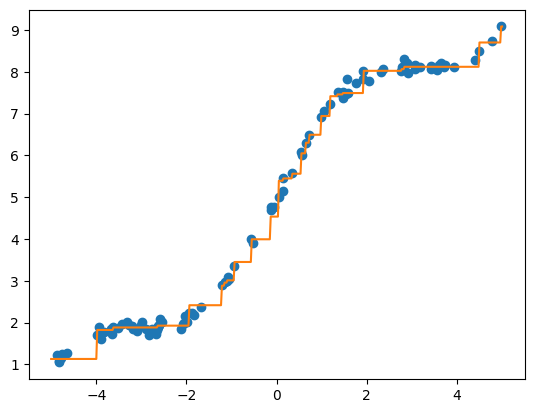

In [64]:
X_test = np.linspace(-5, 5, num=500)
X_test = np.expand_dims(X_test, axis=1)
gbt = GBTRegressor()
gbt.fit(X,y)
y_pred = gbt.predict(X_test)
plt.plot(X,y,'o')
plt.plot(X_test,y_pred,'-')

Narysuj wynik modelu z odpowednio 1, 2, 5, 10 i 100 klasyfikatorami bazowami. Za klasfikator bazowy przyjmij decision stump.

C:\Users\Marcin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Marcin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Marcin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


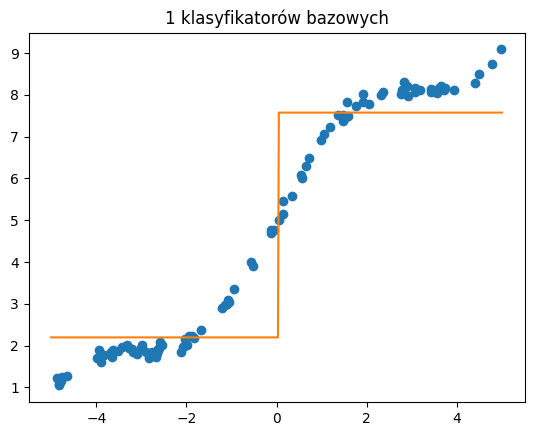

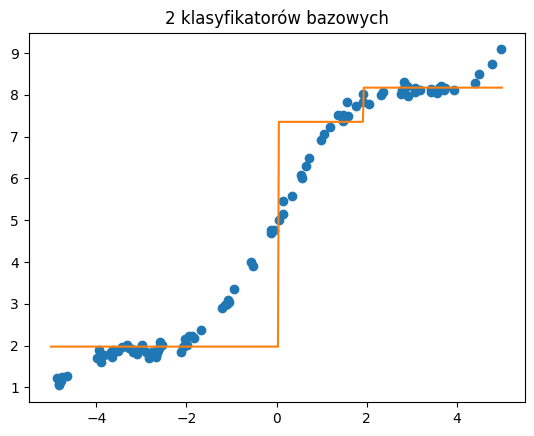

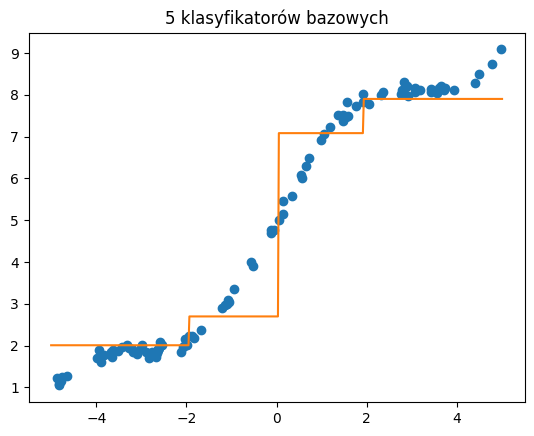

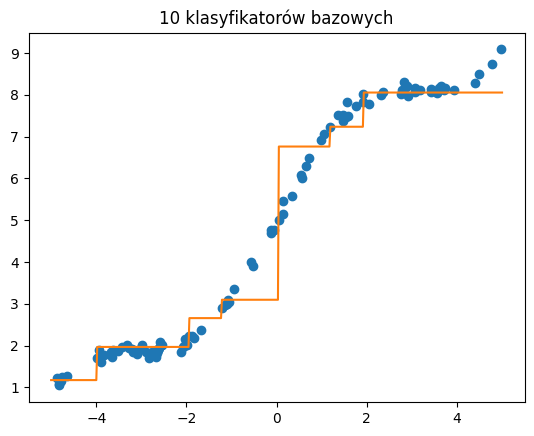

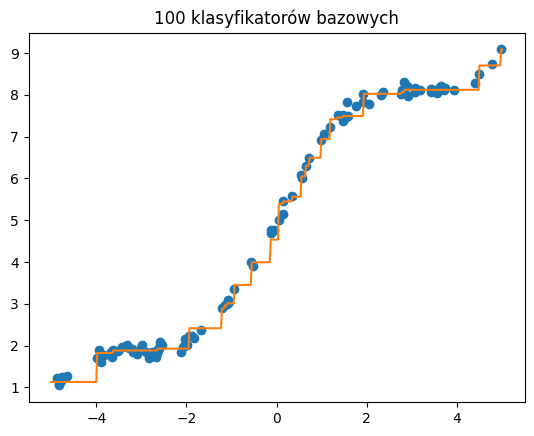

In [80]:
X_test = np.linspace(-5, 5, num=500)
X_test = np.expand_dims(X_test, axis=1)

def draw_plots(x, M):
    gbt = GBTRegressor()
    gbt.fit(X,y, M=M)
    y_pred = gbt.predict(x)
    plt.title(f"{M} klasyfikatorów bazowych")
    plt.plot(X,y,'o')
    plt.plot(X_test,y_pred,'-')
    plt.show()

for M in [1, 2, 5, 10, 100]:
    draw_plots(X_test, M)

Sprawdź jak zmieniają się wartości redyduów w kilku początkowych iteracjach GBT. Narysuj wykresy $x$ vs $y-\hat{y}$ - zwróć uwagę, że tak właśnie wyglądają zbiory na których uczą się kolejne klasyfikatory.

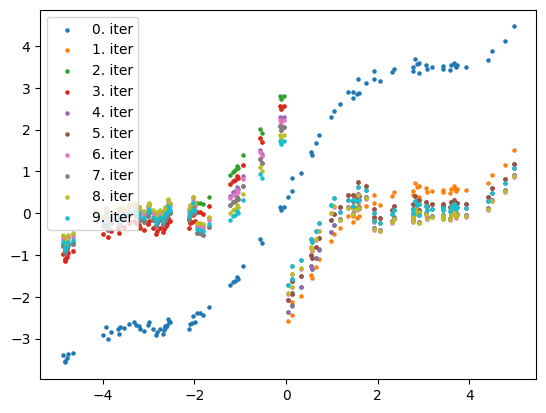

In [79]:
gbt = GBTRegressor()
gbt.fit(X,y, M=100)

for i in range(10):
    plt.scatter(X, gbt.pseudo_residuals[i], label=f"{i}. iter", s = 5)
plt.legend(loc='upper left')
plt.show()

*Odpowiedzi:*
- model początkowy $F_0(x)$
$$F_0(x) = \arg \min_v \sum_{i=1}^N L(y_i, v) = \frac{1}{2} \sum_{i=1}^N (y_i- v)^2 $$
wartość ta to oczywiście średnia arytmetyczna $v = \frac{1}{n} \sum_{i=1}^N y_i$. (Upewnij się, że to rozumiesz poprzez policzenie pochodnej i przyrównanie jej do 0).
- wzór na wartość ujemnego gradientu tj. pseudo-rezyduum 
$$r_i  =  - \frac{\partial}{\partial \hat{y_i}} L(y_i, \hat{y_i}) = - \frac{\partial}{\partial \hat{y_i}} \frac{1}{2}(y_i- \hat{y_i})^2$$
Co po przekształceniach wykorzystujących regułę łańcuchową ("pochodna zewnętrzna razy pochodna wewnętrzna"):
$$r_i  = -\frac{1}{2} 2(y_i- \hat{y_i})\frac{\partial}{\partial \hat{y_i}} (y_i- \hat{y_i}) 
= -(y_i- \hat{y_i})\cdot(-1)
= y_i- \hat{y_i}  $$
- wzór na wartość liścia $v$ optymalizujący funkcję celu
$$v = \arg \min_v \sum_{i=1}^{N_l} L(y_i, F_{m-1}(x_i) + v) = \frac{1}{2} \sum_{i=1}^{N_l} (y_i- F_{m-1}(x_i) - v)^2 $$
Co można dalej obliczyć poprzez przyrównanie pochodnej do 0 lub poprzez zauważenie że jest to w naszej sytuacji ten sam wzór co dla modelu początkowego gdzie $y_i$ zostało zastępione $y_i- F_{m-1}(x_i)=r_i$. W związku z tym wartość liścia to $v = \frac{1}{n} \sum_{i=1}^N r_i$

## Zadanie 2
Zaimplementuj GBT dla problemu klasyfikacji binarnej, który będzie optymalizował błąd regresji logicznej tj. entropię krzyżową wyrażoną wzorem:
$$L(y_i, \hat{p_i}) = y_i \log \hat{p_i} +  (1-y_i) \log (1-\hat{p_i}) $$
gdzie $y_i\in \{0,1\}$ to prawdziwa wartość klasy a $\hat{p_i}$ to predykcja klasyfikatora dla $i$-tego elementu.

- Zauważ, że GBT wykorzystuje drzewa regresji, które - choć modyfikujemy im sposób obliczania liści - nadal tworzą podziały dla miary SSE. Aby wykorzystać GBT do problemu klasyfikacji, należy zastanowić się jak możemy wykorzystać regresor do klasyfikacji. Ten problem rozwiązywaliśmy już wcześniej przy omawianiu regresji logistycznej, gdzie tworzyliśmy klasyfikator z modelu regresji liniowej. Przypomnijmy, że w regresji logistycznej model regresji liniowej służy do predykcji logitu prawdopodobieństwa klasy (który przypomnijmy ma zakres wartości od $-\infty$ do $\infty$)
$$\text{logit}(p_x) = \ln \frac{p_x}{1-p_x}=w^Tx+b$$
Podobnie w GBT należy skonstruować model regresji do przewidywania wartości $\text{logit}(p_x)$, a jedynie przy predykcji (lub kiedy jest to wygodne) transformować go do prawdopodobieństwa klasy funkcją sigmoidalną $p_x  = \frac{1}{1+e^{- \text{logit}(p_x)}}  $

**Zadania**

1. Powyższy zapis funkcji celu $L(y_i, \hat{p_i})$ jest wyrażony w zależności od prawdopodobieństwa klasy, a nie wartości logitu $L(y_i, \text{logit}(\hat{p_i}))$. Przekształć wzór na funkcję celu, aby jej argumentem był logit. Zwróć uwagę, że model regresji będzie przewidywał właśnie logit, więc przy wyznaczaniu elementów algorytmu GBT należy liczyć np. pochodne tej właśnie przekształconej funkcji.

    Zapisz wzór na tę funkcję w komórce poniżej (np. w komentarzu, nie musisz implementować).


$$logit(p) = ln\frac{p}{1-p}$$

$$p = \frac{e^{logit(p)}}{1 + e^{logit(p)}} = \frac{1}{1 + e^{-logit(p)}}$$

$$\hat{y_i} = logit(\hat{p_i})$$

$$L(y_i, \hat{y_i}) = y_i  log(\frac{1}{1+e^{-logit(p_i)}}) + (1 - y_i) log(1 - \frac{1}{1 + e^{-logit(p_i)}}) = $$
$$ = y_i  log(\frac{1}{1+e^{-\hat{y_i}}}) + (1 - y_i) log(1 - \frac{1}{1 + e^{-\hat{y_i}}}) = -y_i  log(\frac{1}{1+e^{\hat{y_i}}}) - (1 - y_i) log(1 - \frac{1}{1 + e^{\hat{y_i}}})

2. Zacznijmy uzupełniać w ogólnym pseudokodzie przedstawionym na zajęciach brakujące elementy. Wyznacz model początkowy $F_0(x)$ zwracający stałą wartość $v$ która optymalizuje błąd:
$$F_0(x) = \arg \min_v \sum_{i=1}^N L(y_i, v) $$


$$p = \frac{e^{logit(p)}}{1 + e^{logit(p)}}$$
$$\frac{\partial}{\partial logit(p)}\sum_{i=1, ..., n} L = -\sum_{i=1, ..., n} y_i + n \frac{e^{logit(p)}}{1 + e^{logit(p)}} = - \sum_{i=1, ..., n} y_i + np$$

$$ - \sum_{i=1, ..., n} y_i + np = 0$$
$$ p = \frac{1}{n} \sum_{i=1, ..., n} y_i = \bar{y}$$

$$F_0(x) = v = log(\frac{\bar{y}}{1 - \bar{y}})

3. Wyznacz wzór na wartość ujemnego gradientu tj. pseudo-rezyduum:
$$r_i  =  - \frac{\partial}{\partial \hat{y_i}} L(y_i, \hat{y_i}) $$
Uwaga: na samym końcu, aby wzór uzykał prostszą formę, możesz zamienić w nim wartości logitów z powrotem na prawdopodobieństwa.

$$r_i = \frac{\partial}{\partial \hat{y_i}}[y_i \hat{y_i} - log(1 + e^{\hat{y_i}})] = y_i - \frac{e^{\hat{y_i}}}{1 + e^{\hat{y_i}}} = y_i - \hat{p_i}$$

4. Wzór na wartość liścia $v$ optymalizujący funkcję celu całego modelu GBT
$$v = \arg \min_v \sum_{i=1}^{N_l} L(y_i, F_{m-1}(x_i) + v) $$
niestety nie jest prosty do wyznaczenia w tym przypadku. Stosuje się przybliżenie Taylora drugiego rzedu tej funkcji i wtedy optimum ma postać:
$$v = \frac{-\sum_{i=1}^{N_L} L_i' }{\sum_{i=1}^{N_L} L_i''}$$
gdzie $L_i'$ i $L_i''$ to skrócony zapis pierwszej i drugiej pochodnej policzonej po funkcji straty dla $i$-tego elementu. Ponieważ $r_i=-L_i'$ to licznik przyjmuje postać $\sum_{i=1}^{N_L} r_i $. Wyznacz cały wzór.



$$v = \frac{\sum_{i=1, ..., N_L}(y_i - \hat{p_i})}{\sum_{i=1, ..., N_L}(\hat{p_i} - \hat{p_i}^2)} = \frac{\sum_{i=1, ..., N_L}(y_i - \hat{p_i})}{\sum_{i=1, ..., N_L}\hat{p_i}(1 - \hat{p_i})}$$

Wykorzystując uzyskane wyniki zaimplementuj algorytm. 

In [36]:
import scipy.special
# Wskazówka: scipy.special.expit() implemenuje funkcję sigmoidalną

class GBTClassifier(object):
    
    def __init__(self):
        self.trees = [] # Lista kolejnych drzew (Node) klasyfikatora
        self.initial_model = None # Model początkowy, zwracający stałą wartość 
                                  #(zmienna po prostu przechowuje tę wartość)
        
    def calc_leaf(self, X, y, last_predicted):
        """
        Funkcja do wykorzystania jako argument klasyfikatora bazowego Node
        """
        der = np.sum(last_predicted * (1 - last_predicted))
        return np.sum(y) / der
        
    def fit(self, X, y, M = 100, max_depth = 1):
        """ 
        Funckja trenująca model GBT o M klasyfikatora bazowych
        z maksymalną głębkością pojedynczego drzewa max_depth
        """
        self.initial_model = np.log(np.mean(y) / (1 - np.mean(y)))
        mean_score = np.array([np.mean(y) for _ in y])

        for _ in range(M):
            res = y - mean_score
            tree = Node(calculate_leaf_value=self.calc_leaf)
            tree.fit(X, res, last_predicted=mean_score, max_depth=max_depth)
            mean_score += tree.predict(X)
            self.trees.append(tree)
            
    def predict(self, X):
        """
        Zwrócenie predykcji dla obiektów testowych X
        """
        predicted = np.sum([tree.predict(X) for tree in self.trees], axis=0)
        return scipy.special.expit(predicted + self.initial_model)

Przetestuj swoją implementację na zbinaryzowanym zbiorze `iris`.

C:\Users\Marcin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Marcin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Marcin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


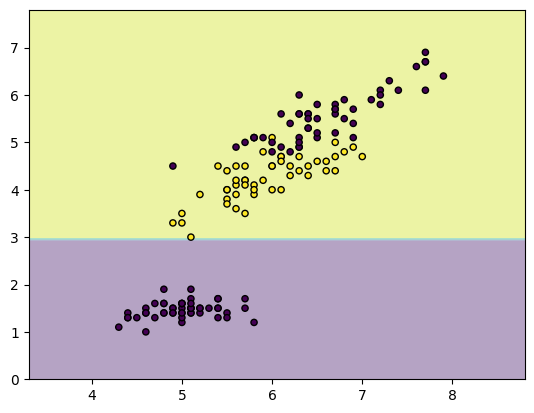

In [37]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target
y[y==2] = 0 # Sprowadzenie problemu do klasyfikacji binarnej

# Kod rysowania
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

clf = GBTClassifier()
clf.fit(X,y)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.show()

Narysuj granice decyzji klasyfikatora dla 10, 20, 50 i 100 iteracji algorytmu dla klasyfikatora bazowego o maksymalnej głębokości 1 i 2.

C:\Users\Marcin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Marcin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Marcin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


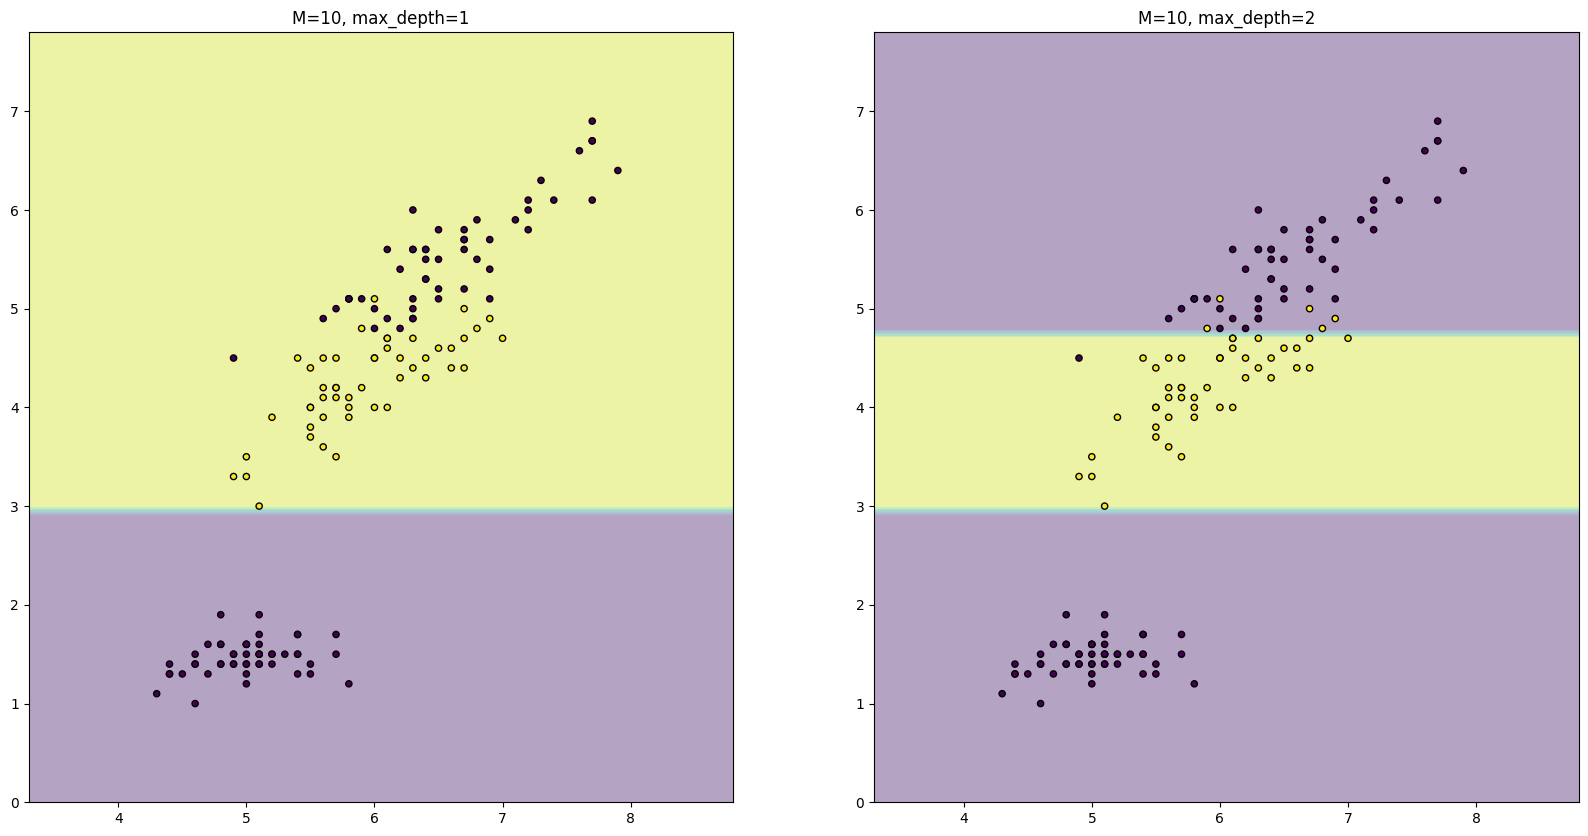

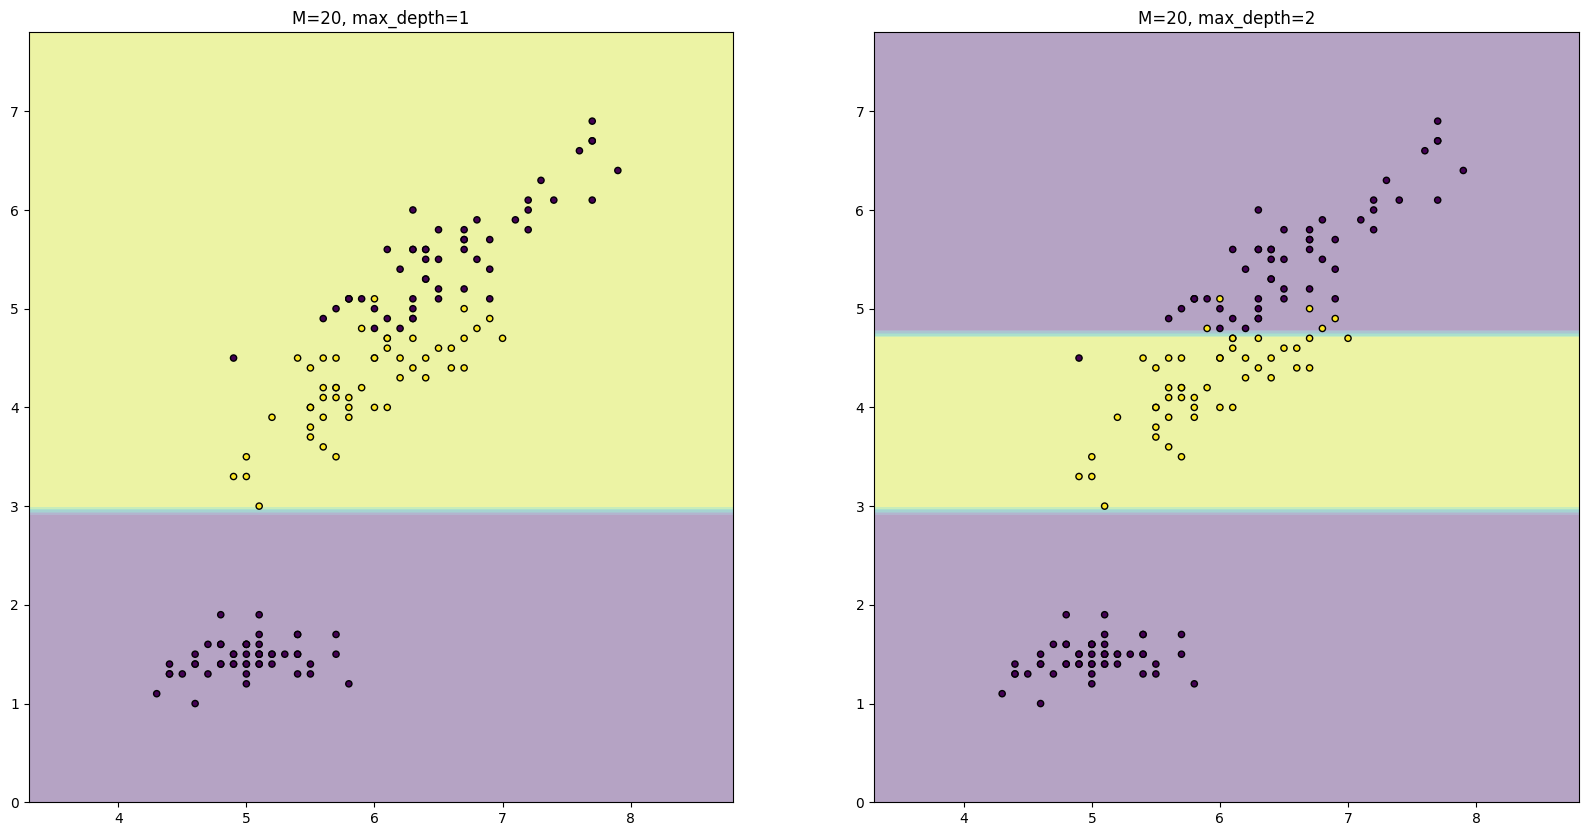

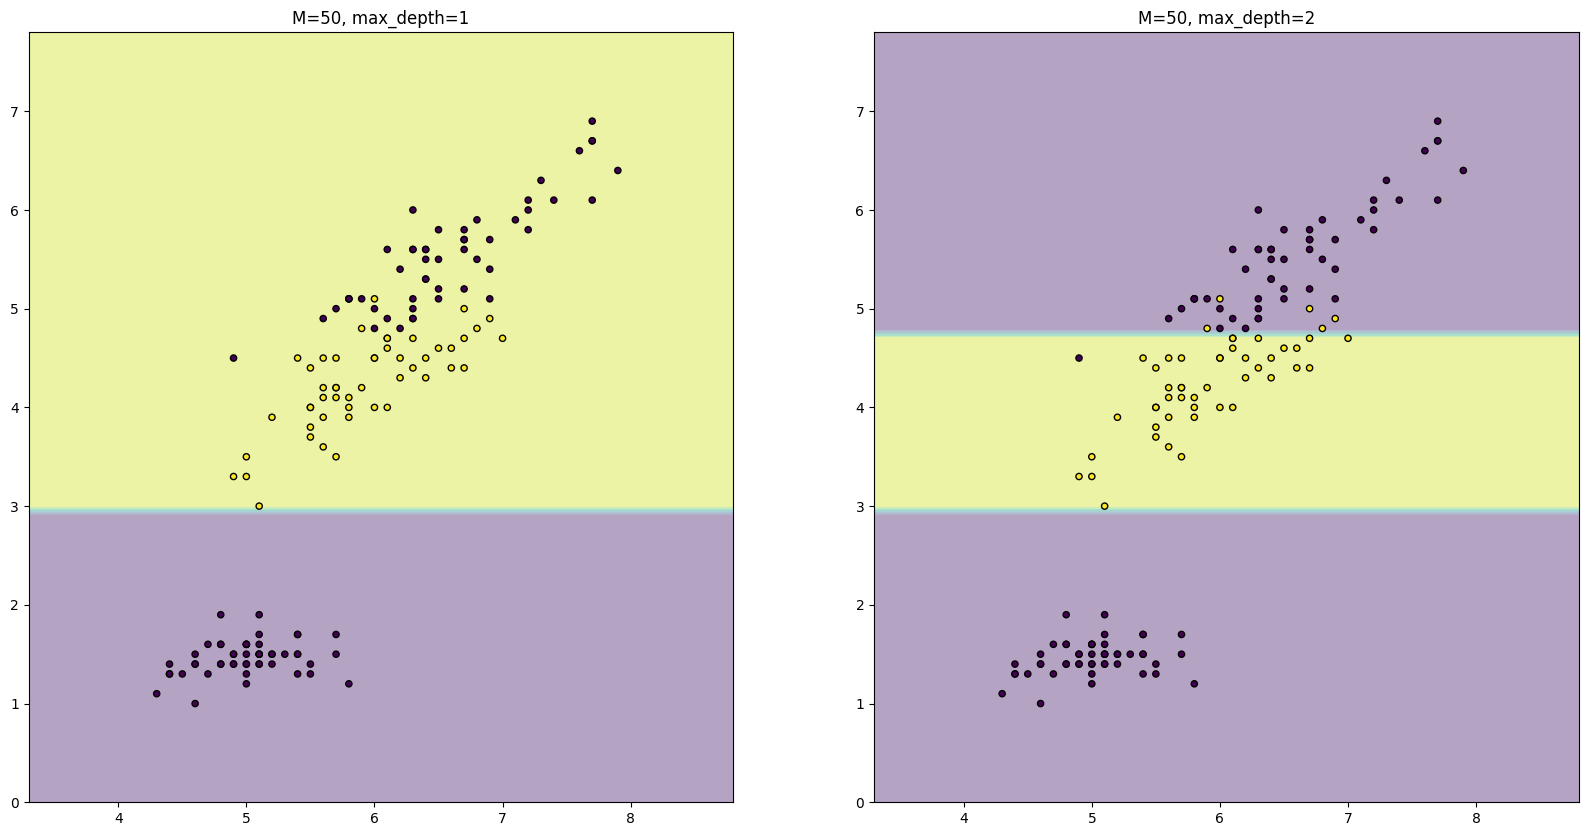

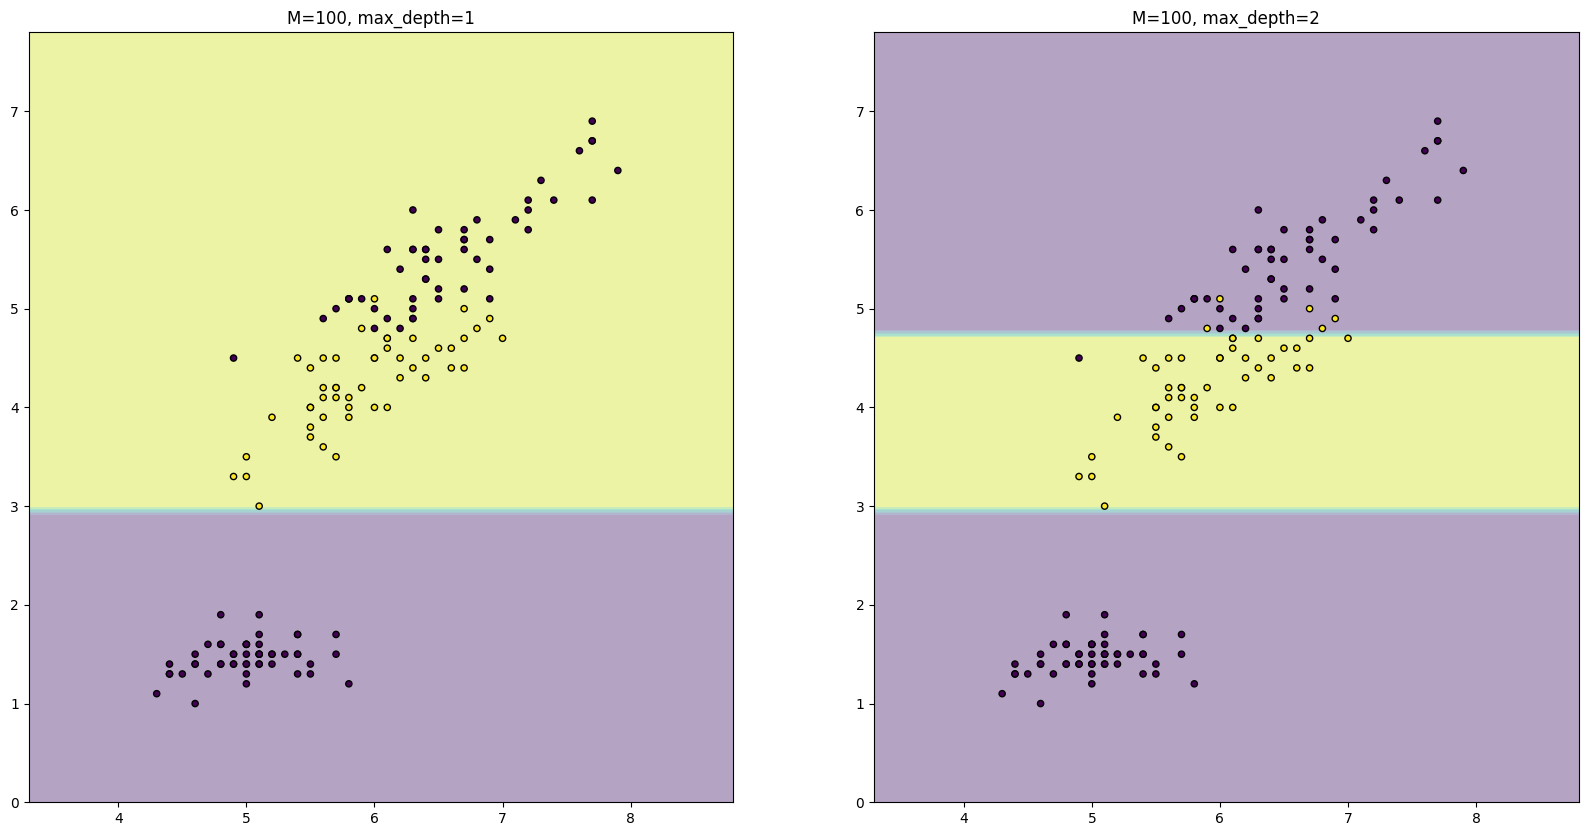

In [81]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target
y[y==2] = 0 # Sprowadzenie problemu do klasyfikacji binarnej

# Kod rysowania
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


def draw_clf_plots():
    for M in [10, 20, 50, 100]:
        fig, axis = plt.subplots(1, 2, figsize=(20,10)) 
        for md in [1,2]:
            clf = GBTClassifier()
            clf.fit(X,y, M = 10, max_depth = md)
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            axis[md - 1].contourf(xx, yy, Z, alpha=0.4)
            axis[md - 1].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
            axis[md - 1].set_title(f"M={M}, max_depth={md}")
        plt.show()

draw_clf_plots()

**Ćwiczenia**
1. Przeanalizuj wyniki powyższego eksperymentu i określ w których sytuacjach nastąpiło przeuczenie.
2. W jaki sposób zaimplementować GBT dla problemu klasyfikacji wieloklasowej?
3. W powyższym problemie który z klasyfikatorów bazowych (o jakiej max. głębokości) poradził sobie lepiej? Czy jest sens stosować w tym problemie drzewa o głębokości większej niż testowana (tj. 2). Odpowiedź uzasadnij.
4. Dodaj do implementacji parametr $\eta$ i przetestuj kilka jego wartości. Pamętaj, że $\eta$ powinno być wykorzystywane nie tylko w funkcji `fit`, ale także `predict` - dlaczego?

Odpowiedź na trzecią kropkę umieść poniżej.

YOUR ANSWER HERE

## Zadanie 3
GBT jest bardzo popularnym algorytmem głównie dzięki bardzo efektywnym implementacjom potrafiącym sobie radzić z dużymi zbiorami danych. W tym ćwiczeniu Twoim zadaniem jest nauczenie się podstaw obsługi biblioteki `catboost`, którą powinieneś zainstalować.

Wczytanie zbioru danych `iris` z poprzedniego zadania.

In [47]:
from catboost import CatBoostClassifier
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target
y[y==2] = 0 # Sprowadzenie problemu do klasyfikacji binarnej

Trening modelu

In [48]:
model = CatBoostClassifier(logging_level='Silent')
model.fit(X, y, eval_set=(X, y), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Przykładowy kod ewaluuje działanie algorytmu na części uczącej. Podziel zbiór na część uczącą i testową i ponownie uruchom algorytm. 


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(logging_level='Silent')
model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Gdybyś porównał wartość funkcji straty osiągniętej przez catboost z wartością uzyskaną Twoją implementacją na zbiorze uczącym przy analogicznej liczbie drzew (domyślnie w `GBTClassifier` $M=100$) to wartość ta będzie najprawdopodobniej niższa dla... Twojej implementacji. Dlaczego? Czy to oznacza, że - pomijając aspekt wydajności obliczeń - Twoja metoda działa lepiej niż catboost?

*Dla chętnych*: porównaj wartość funkcji straty osiągniętej przez catboost z Twoją implementacją z zadania 2.

YOUR ANSWER HERE

Zaimportuj dowolny większy i bardziej wymagający zbiór danych. Ćwiczenie możesz wykonać na [dowolnym zbiorze danych](https://catboost.ai/docs/concepts/python-reference_datasets.html) - ładowanie zbioru może trochę potrwać. Jeśli masz problemy sprzętowe z operowaniem na dużym zbiorze danych to jest też dostępny zbiór `titanic`.

In [50]:
from catboost import datasets

# train_df, test_df = datasets.titanic()
print(train_df.shape, test_df.shape)


(891, 12) (418, 11)


Spróbuj osiągnąć jak najlepszy wynik na wybranym zbiorze poprzez tuning parametrów. Ważne parametry uczenia zostały opisane [tutaj](https://catboost.ai/docs/concepts/python-reference_parameters-list.html).

In [60]:
model = CatBoostClassifier(logging_level='Silent')
grid = dict(
    depth=[2, 5, 10],
    learning_rate=[0.05, 0.1, 0.15],
    iterations=[100, 300, 500, 1000],
    custom_metric=['Logloss', 'AUC'],
    sampling_frequency=['PerTree', 'PerTreeLevel']
)
result = model.grid_search(grid, X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.0867318	best: 0.0867318 (0)	total: 296ms	remaining: 42.3s
1:	loss: 0.0480473	best: 0.0480473 (1)	total: 462ms	remaining: 32.8s
2:	loss: 0.0477655	best: 0.0477655 (2)	total: 633ms	remaining: 29.8s
3:	loss: 0.0419720	best: 0.0419720 (3)	total: 1.16s	remaining: 40.8s
4:	loss: 0.0447454	best: 0.0419720 (3)	total: 1.58s	remaining: 44.1s
5:	loss: 0.0476031	best: 0.0419720 (3)	total: 2.09s	remaining: 48.1s
6:	loss: 0.0364013	best: 0.0364013 (6)	total: 2.77s	remaining: 54.3s
7:	loss: 0.0447454	best: 0.0364013 (6)	total: 3.73s	remaining: 1m 3s
8:	loss: 0.0476031	best: 0.0364013 (6)	total: 4.36s	remaining: 1m 5s
9:	loss: 0.0364013	best: 0.0364013 (6)	total: 5.86s	remaining: 1m 18s
10:	loss: 0.0447454	best: 0.0364013 (6)	total: 7.25s	remaining: 1m 27s
11:	loss: 0.0476031	best: 0.0364013 (6)	total: 8.68s	remaining: 1m 35s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
12:	loss: 0.0867318	best: 0.03640

Jakie ustawienia parametrów dały najlepszy wynik na wybranym zbiorze danych? Które z parametrów algorytmu miały najsilniejszy wpływ na ostateczny wynik?

Parametry, dla których algorytm dał najlepsze wyniki:
- sampling_frequency = 'PerTreeLevel'
- depth = 2
- custom_metric = 'Logloss'
- learning_rate = 0.15
- iterations = 300

Największy wpływ na wynik ma `learning_rate` oraz liczba iteracji.

**Uwaga** Przed wysłaniem zadania domowego wróć do komórki w której ładowałeś zbiór danych i zakomentuj ją, aby niewykonała się ona na sprawdzarce.